In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import matplotlib as mpl
import os
from matplotlib.lines import Line2D
from collections import Counter
import math
from sklearn.decomposition import PCA
from aging.behavior.syllables import relabel_by_usage
from tqdm import tqdm
%matplotlib inline
import warnings
warnings.simplefilter('ignore')
import random
import scipy
from aging.plotting import format_plots, PlotConfig, save_factory, figure, legend, format_pizza_plots

In [17]:
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from matplotlib.gridspec import GridSpec
from collections import defaultdict
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import ShuffleSplit
from sklearn.svm import LinearSVC
from sklearn.model_selection import GroupKFold, LeaveOneGroupOut, LeaveOneOut, KFold
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, r2_score, confusion_matrix
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cross_decomposition import PLSRegression

In [18]:
format_plots()
#format_pizza_plots()
c = PlotConfig()

In [19]:
from matplotlib.colors import LinearSegmentedColormap
# Define the color map
colors = ['#fee6ce','#d94801']
custom_cmap = LinearSegmentedColormap.from_list("custom_purples", colors, N=256)
cmf=custom_cmap

In [20]:
## update data
def filter_df(df):
    max=39
    syll=df.columns.values[df.columns.values>max]
    df.drop(syll,axis=1, inplace=True)
    return df[~df.index.get_level_values('session_name').str.contains('CRL')]

In [21]:
# arrange data
path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/dana_ontogeny_females_relabeled_usage_matrix_v00.parquet')
df_dana = pd.read_parquet(path)

path = Path('/n/groups/datta/win/longtogeny/data/ontogeny/version_11/ontogeny_females_relabeled_usage_matrix_v00.parquet')
df = pd.read_parquet(path)

# arrange data
data = df.astype(float, errors='ignore')
data= filter_df(data).groupby(['age','uuid']).mean()
data['data'] = 'min'
data.set_index('data', inplace=True, append=True)

data_dana = df_dana.astype(float, errors='ignore')
data_dana= filter_df(data_dana).groupby(['age','uuid']).mean()
data_dana['data'] = 'dana'
data_dana.set_index('data', inplace=True, append=True)

data_all = pd.concat([data,data_dana])
# choose 16 mice from all dataset
random_seed = 0
n=16
data_all = data_all.groupby('age').apply(lambda x: x.sample(n=n,replace=False,random_state=random_seed) if len(x)>n else x.sample(n=len(x),replace=False,random_state=random_seed)).reset_index(level=0, drop=True)
data_all = data_all[sorted(data_all.columns)]
m_data=data_all.copy()

In [22]:
male_data=m_data.copy()

In [23]:
male_data.index.get_level_values('age').value_counts()

age
3      16
4      16
84     16
78     16
72     16
68     16
64     16
60     16
56     16
52     16
48     16
44     16
40     16
36     16
32     16
24     16
20     16
16     16
12     16
9      16
8      16
7      16
5      16
28     15
80     15
127     8
90      7
Name: count, dtype: int64

In [8]:
# process data

In [9]:
# choose a model for decoder
#clf = KNeighborsRegressor(n_neighbors=10)
clf = PLSRegression(n_components=5)
#clf = svm.SVC(kernel='linear') 
#clf = RandomForestClassifier(n_estimators = 100)
#clf = LinearRegression()
# choose cross validation scheme
cv = LeaveOneOut()

#number of iterations for shuffle
it=1000

In [10]:
#prepare data
data=male_data.copy()
y_age =data.index.get_level_values('age').to_numpy()
X=data.to_numpy()
#X=np.log(X + 1e-6) # convert to linear

In [11]:
#decoder
y_pred = cross_val_predict(clf, X, y_age, cv=cv)
r2_age = r2_score(y_age, y_pred)
mse_age = mean_squared_error(y_age, y_pred)
print(r2_age)

0.688838406929025


In [15]:
from scipy.stats import pearsonr
print(pearsonr(y_age, y_pred.flatten()))

PearsonRResult(statistic=0.8302345825768656, pvalue=2.2606633645515425e-106)


In [12]:
res_age = y_age.flatten()-y_pred.flatten()

In [13]:
res_less = res_age[res_age<0]
res_more = res_age[res_age>0]

In [14]:
print(np.mean(abs(res_less)))
print(np.mean(abs(res_more)))

12.061106260843275
12.512788790009004


In [12]:
#shuffle
ysh_score_age=[]
ysh_age=[]
ysh_predict_age=[]
ysh_mse_age=[]
for i in tqdm(range(it)):
    ysh_temp=np.random.permutation(y_age)
    y_pred_temp = cross_val_predict(clf, X, ysh_temp, cv=cv)
    ysh_score_age.append(r2_score(y_age, y_pred_temp))
    ysh_age.extend(ysh_temp)
    ysh_predict_age.extend(y_pred_temp)
    ysh_mse_age.append(mean_squared_error(y_age, y_pred_temp))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [19:48<00:00,  1.19s/it]


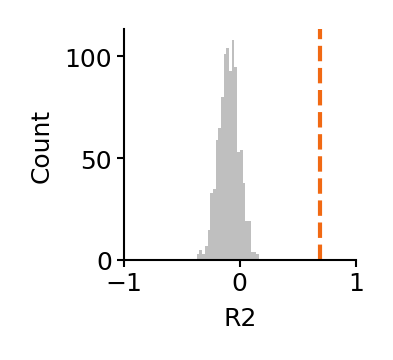

In [13]:
fig = plt.figure(figsize=(1, 1))
fig.dpi = 300
ax = sns.histplot(data=ysh_score_age, fill=True, element='step', lw=0, color='black', alpha=0.25)
ax.axvline(r2_age, color='#f16913', lw=1, linestyle='--')

ax.set(ylabel='Count')
ax.set(xlabel='R2')
plt.xlim([-1,1])
sns.despine()
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig3"/ 'female_age_regression.pdf', bbox_inches='tight')

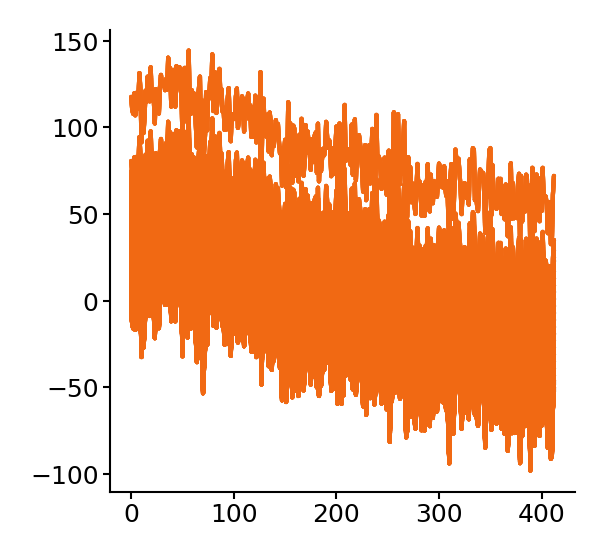

In [14]:
# plot residuals
#X=np.log(X + 1e-6) # convert to linear
res_age = y_age-y_pred
fig = plt.figure(figsize=(2, 2))
fig.dpi = 300
plt.plot (res_age, color='#f16913', lw=1, alpha=0.7)
#plt.ylim([-20, 5])
sns.despine()
c = PlotConfig()
fig.savefig(c.dana_save_path / "fig3"/ 'female_age_regression_residuals.pdf', bbox_inches='tight')

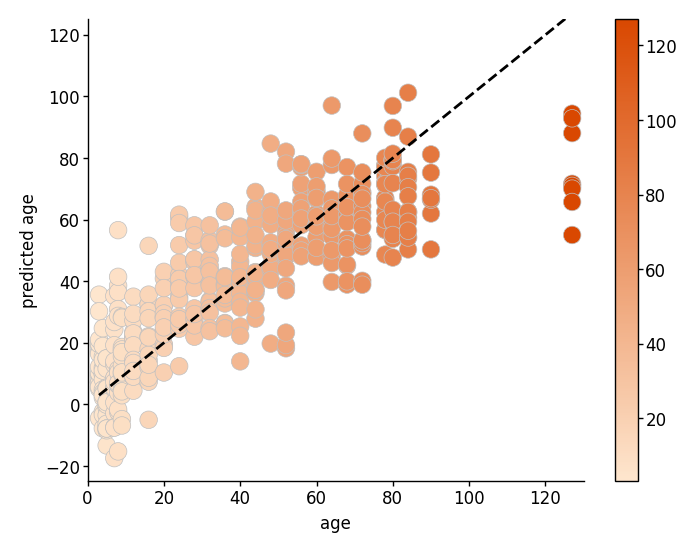

In [17]:
fig, ax = plt.subplots()
fig.set_size_inches(4,3) 
plt.scatter(x=y_age, y=y_pred, 
            s=40, 
            c=y_age, 
            edgecolor='silver',
            linewidth=0.25,
            #norm='log',
            cmap=cmf)
sns.despine()
norm = plt.Normalize(y_age.min(), y_age.max())
sm = plt.cm.ScalarMappable(cmap=cmf, norm=norm)
sm.set_array([])
plt.ylim([-25, 125])
plt.xlim([0, 130])
plt.xlabel('age')
plt.ylabel('predicted age')
plt.plot(y_age, y_age, linestyle='--', color='black')
# Remove the legend and add a colorbar
ax.figure.colorbar(sm)
c = PlotConfig()
plt.savefig(c.dana_save_path / "fig3"/ 'decoder_true_vs_predicted_female.pdf', bbox_inches='tight')